# Iterate on Data validation with display analysis


<b>With this tutorial you:</b><br />
Understand how to use Eurybia to iterate on different phases of data validation<br />
We propose to go into more detail about the use of Eurybia<br />

Contents:
- Validate your data  
- Generate Report 
- Iterate on analysis of results, data validation, data preparation

Data from Kaggle [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

**Requirements notice** : the following tutorial may use third party modules not included in Eurybia.  
You can find them all in one file [on our Github repository](https://github.com/MAIF/eurybia/blob/master/requirements.dev.txt) or you can manually install those you are missing, if any.

In [2]:
import pandas as pd
from category_encoders import OrdinalEncoder
from lightgbm import LGBMRegressor
from eurybia.core.smartdrift import SmartDrift
from sklearn.model_selection import train_test_split

/Users/78176D/workspace/eurybia/eurybia/report/generation.py:18: UserWarning:

Using Panel interactively in VSCode notebooks requires the jupyter_bokeh package to be installed. You can install it with:

   pip install jupyter_bokeh

or:
    conda install jupyter_bokeh

and try again.



## Import Dataset and split in training and production dataset

In [3]:
from eurybia.data.data_loader import data_loading

In [4]:
house_df, house_dict = data_loading('house_prices')

In [5]:
house_df.tail()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1456,2-Story 1946 & Newer,Residential Low Density,7917,Paved,Regular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Inside lot,Gentle slope,Gilbert,...,0,0,0,0,0,8,2007,Warranty Deed - Conventional,Normal Sale,175000
1457,1-Story 1946 & Newer All Styles,Residential Low Density,13175,Paved,Regular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Inside lot,Gentle slope,Northwest Ames,...,0,0,0,0,0,2,2010,Warranty Deed - Conventional,Normal Sale,210000
1458,2-Story 1945 & Older,Residential Low Density,9042,Paved,Regular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Inside lot,Gentle slope,Crawford,...,0,0,0,0,2500,5,2010,Warranty Deed - Conventional,Normal Sale,266500
1459,1-Story 1946 & Newer All Styles,Residential Low Density,9717,Paved,Regular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Inside lot,Gentle slope,North Ames,...,112,0,0,0,0,4,2010,Warranty Deed - Conventional,Normal Sale,142125
1460,1-Story 1946 & Newer All Styles,Residential Low Density,9937,Paved,Regular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Inside lot,Gentle slope,Edwards,...,0,0,0,0,0,6,2008,Warranty Deed - Conventional,Normal Sale,147500


In [6]:
# For the purpose of the tutorial split dataset in training and production dataset
# To see an interesting analysis, let's test for a bias between  date of construction of training and production dataset
house_df_learning = house_df.loc[house_df['YearBuilt'] < 1980]
house_df_production = house_df.loc[house_df['YearBuilt'] >= 1980]


In [7]:
y_df_learning=house_df_learning['SalePrice'].to_frame()
X_df_learning=house_df_learning[house_df_learning.columns.difference(['SalePrice','YearBuilt'])]

y_df_production=house_df_production['SalePrice'].to_frame()
X_df_production=house_df_production[house_df_production.columns.difference(['SalePrice','YearBuilt'])]

## Use Eurybia for data validation

In [8]:
from eurybia import SmartDrift

In [9]:
SD = SmartDrift(df_current=X_df_production,
                df_baseline=X_df_learning
               )

In [10]:
%time 
SD.compile(full_validation=True # Optional: to save time, leave the default False value. If True, analyze consistency on modalities between columns.
                )

CPU times: user 4 μs, sys: 0 ns, total: 4 μs
Wall time: 6.91 μs
The variable BldgType has mismatching unique values:
[] | ['Two-family Conversion; originally built as one-family dwelling']

The variable BsmtCond has mismatching unique values:
[] | ['Poor -Severe cracking, settling, or wetness']

The variable CentralAir has mismatching unique values:
[] | ['No']

The variable Condition1 has mismatching unique values:
["Within 200' of East-West Railroad"] | ['Adjacent to arterial street', 'Adjacent to postive off-site feature']

The variable Condition2 has mismatching unique values:
['Near positive off-site feature--park, greenbelt, etc.'] | ['Adjacent to arterial street', "Within 200' of North-South Railroad", 'Adjacent to feeder street', 'Adjacent to postive off-site feature', 'Adjacent to North-South Railroad', 'Adjacent to East-West Railroad']

The variable Electrical has mismatching unique values:
[] | ['60 AMP Fuse Box and mostly Romex wiring (Fair)', 'Fuse Box over 60 AMP and all 

As soon as compile() method, Eurybia displays default consistency checks as warnings.<br />
If some modalities are not present during training and are in production dataset, the deployed model will consider them wrongly.<br />
Inversely, if some modalities are present during training and are not in production dataset, it means that some profiles are missing.

In [11]:
SD.generate_report(    
    output_file='report_house_price_v1.html',    
    title_story="Data validation V1", 
    title_description="""House price Data validation V1""" # Optional: add a subtitle to describe report
    )

Eurybia is designed to generate an HTML report for analysis, and less for use in notebook mode. 
However, to illustrate functionalities, we will detail results with notebook mode analysis.

## First Analysis of results of the data validation

Data validation methodology is based on the ability of a model to discriminate whether an individual belongs to one of the two datasets.
For this purpose a target 0 is assigned to the baseline dataset and a target 1 to the current dataset.
Then a classification model (catboost) is learned to predict this target.
The level of capacity of the data drift classifier to detect if an individual belongs to one of the 2 datasets represents the level of difference between the 2 datasets

### Detection data drift performance

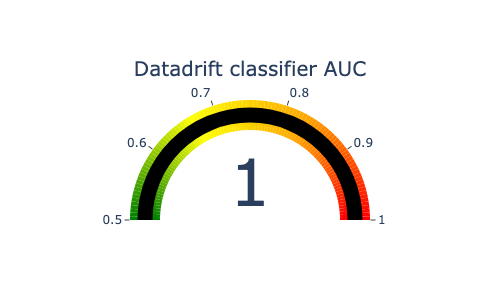

In [ ]:
#Performance of data drift classifier
SD.plot.generate_indicator(fig_value=SD.auc, height=300, width=500, title="Datadrift classifier AUC")

such a high auc means that datasets are not similar.The differences should be analysed before deploying model in production

### Importance of features in data drift

This graph represents the variables in the data drift classification model that are most important to differentiate between the two datasets.

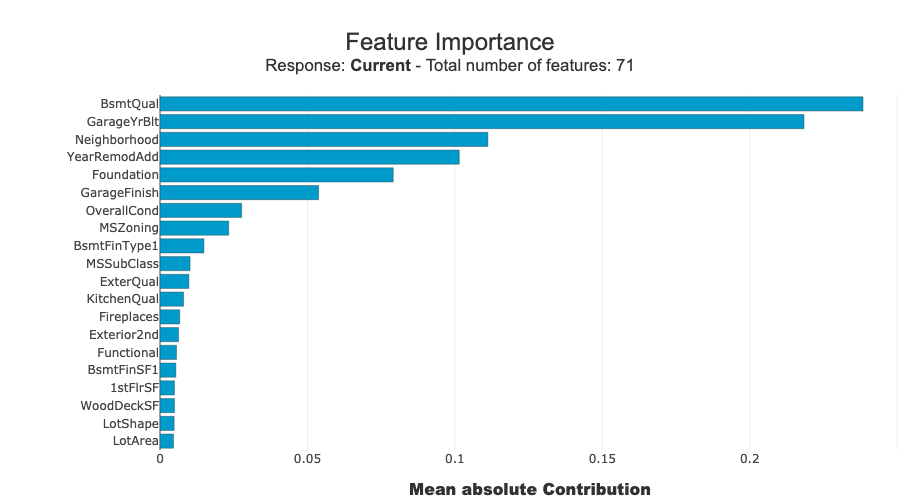

In [ ]:
SD.xpl.plot.features_importance()

We get the features with most gaps, those that are most important to analyse.
With date bias introduced, it is normal that date features are the most impacted. We will then decide to remove them.
Let's analyse other important variables

### Univariate analysis

This graphs shows a particular feature's distribution over its possible values. In the drop-down menu, the variables are sorted by importance of the variables in the data drift classification. For categorical features, the possible values are sorted by descending difference between the two datasets.

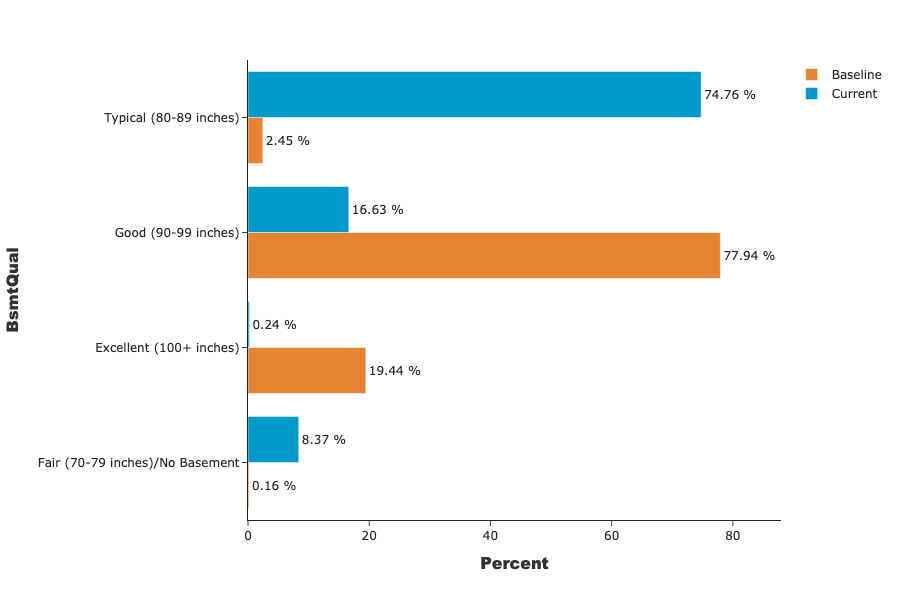

In [ ]:
SD.plot.generate_fig_univariate('BsmtQual')

This feature on height of the basement seems to be correlated with the date of build.To avoid creating too much bias, the data scientist decides to remove it from his learning.

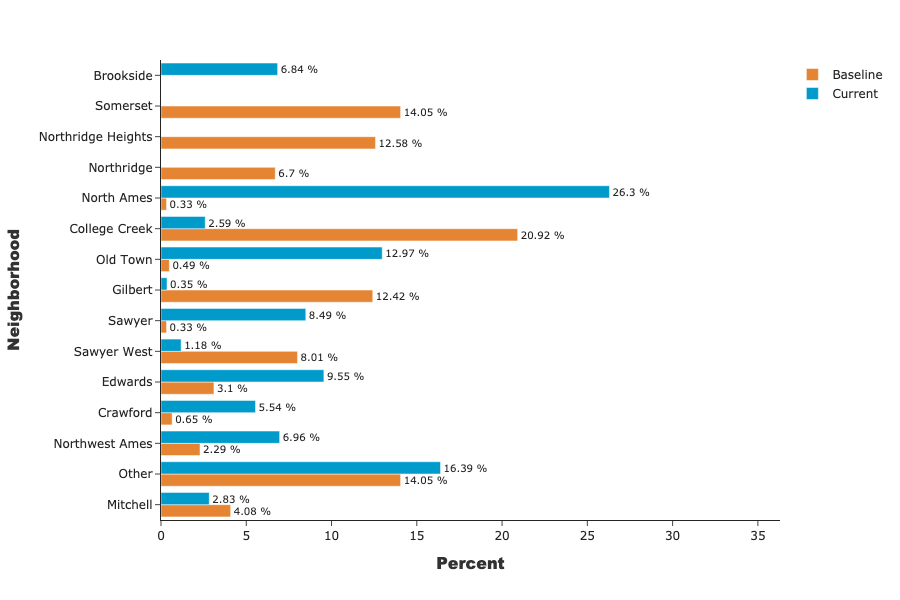

In [ ]:
SD.plot.generate_fig_univariate('Neighborhood')

This feature on neighborhood seems to be correlated with the date of build.To avoid creating too much bias, the data scientist decides to remove it from his learning.

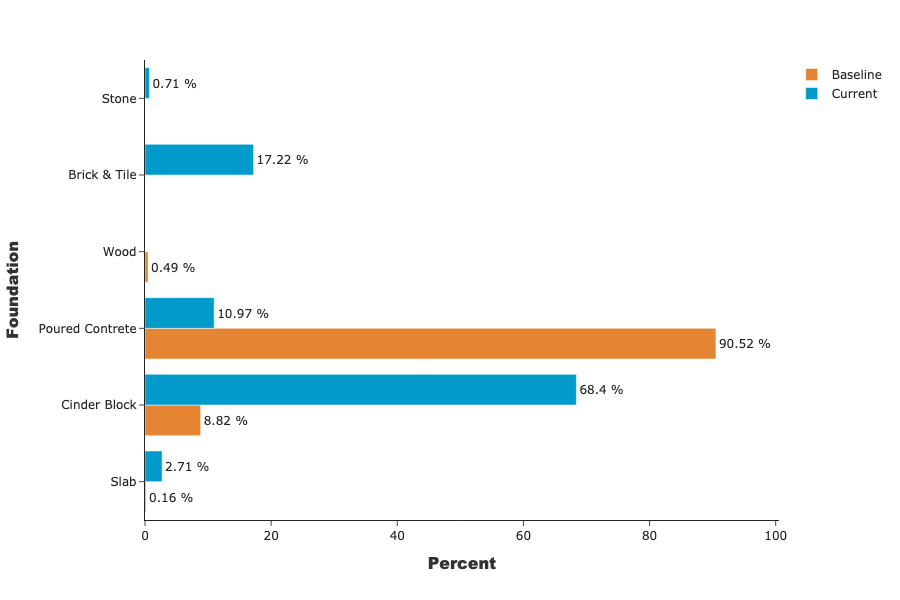

In [ ]:
SD.plot.generate_fig_univariate('Foundation')

This feature on foundation seems to be correlated with the date of build.To avoid creating too much bias, the data scientist decides to remove it from his learning.

Data scientist thus discards all features that will not be similar to the production training

## Second data validation after cleaning data preparation

In [17]:
y_df_learning=house_df_learning['SalePrice'].to_frame()
X_df_learning=house_df_learning[house_df_learning.columns.difference(['SalePrice','YearBuilt','BsmtQual',
                                                'Neighborhood','Foundation','GarageYrBlt','YearRemodAdd',
                                                'GarageFinish','OverallCond','MSZoning','BsmtFinType1','MSSubClass',
                                                'ExterQual','KitchenQual','Exterior2nd','Exterior1st','OverallQual',
                                                'HeatingQC','FullBath','OpenPorchSF','GarageType','GrLivArea','GarageArea'])]

y_df_production=house_df_production['SalePrice'].to_frame()
X_df_production=house_df_production[house_df_production.columns.difference(['SalePrice','YearBuilt','BsmtQual',
                                                'Neighborhood','Foundation','GarageYrBlt','YearRemodAdd',
                                                'GarageFinish','OverallCond','MSZoning','BsmtFinType1','MSSubClass',
                                                'ExterQual','KitchenQual','Exterior2nd','Exterior1st','OverallQual',
                                                'HeatingQC','FullBath','OpenPorchSF','GarageType','GrLivArea','GarageArea'])]

In [18]:
SD = SmartDrift(df_current=X_df_production, df_baseline=X_df_learning)

In [19]:
%time SD.compile(full_validation=True)

The variable BldgType has mismatching unique values:
[] | ['Two-family Conversion; originally built as one-family dwelling']

The variable BsmtCond has mismatching unique values:
[] | ['Poor -Severe cracking, settling, or wetness']

The variable CentralAir has mismatching unique values:
[] | ['No']

The variable Condition1 has mismatching unique values:
["Within 200' of East-West Railroad"] | ['Adjacent to arterial street', 'Adjacent to postive off-site feature']

The variable Condition2 has mismatching unique values:
['Near positive off-site feature--park, greenbelt, etc.'] | ['Adjacent to arterial street', "Within 200' of North-South Railroad", 'Adjacent to feeder street', 'Adjacent to postive off-site feature', 'Adjacent to North-South Railroad', 'Adjacent to East-West Railroad']

The variable Electrical has mismatching unique values:
[] | ['60 AMP Fuse Box and mostly Romex wiring (Fair)', 'Fuse Box over 60 AMP and all Romex wiring (Average)', '60 AMP Fuse Box and mostly knob & tube

In [20]:
SD.generate_report(    
    output_file='report_house_price_v2.html',    
    title_story="Data validation V2", 
    title_description="""House price Data validation V2""" # Optional: add a subtitle to describe report
    )

## Second Analysis of results of the data validation

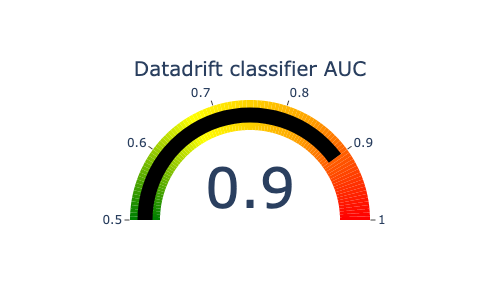

In [ ]:
SD.plot.generate_indicator(fig_value=SD.auc, height=300, width=500, title="Datadrift classifier AUC")

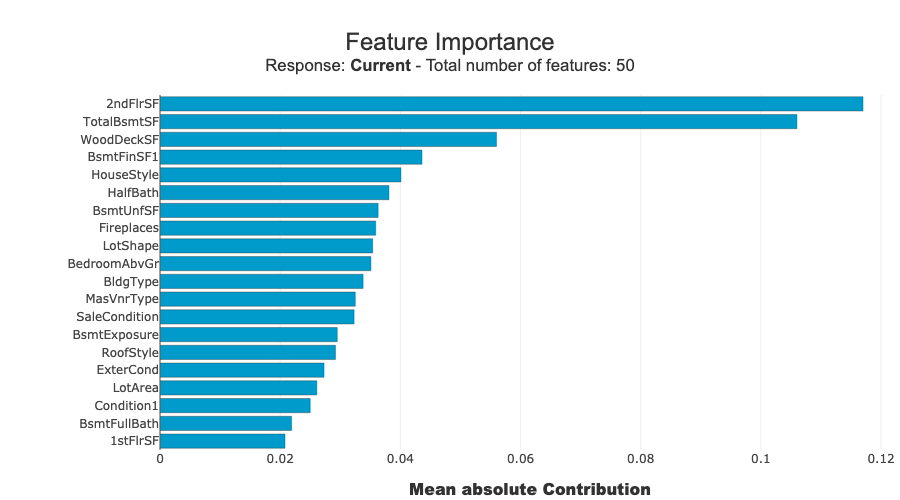

In [ ]:
SD.xpl.plot.features_importance()

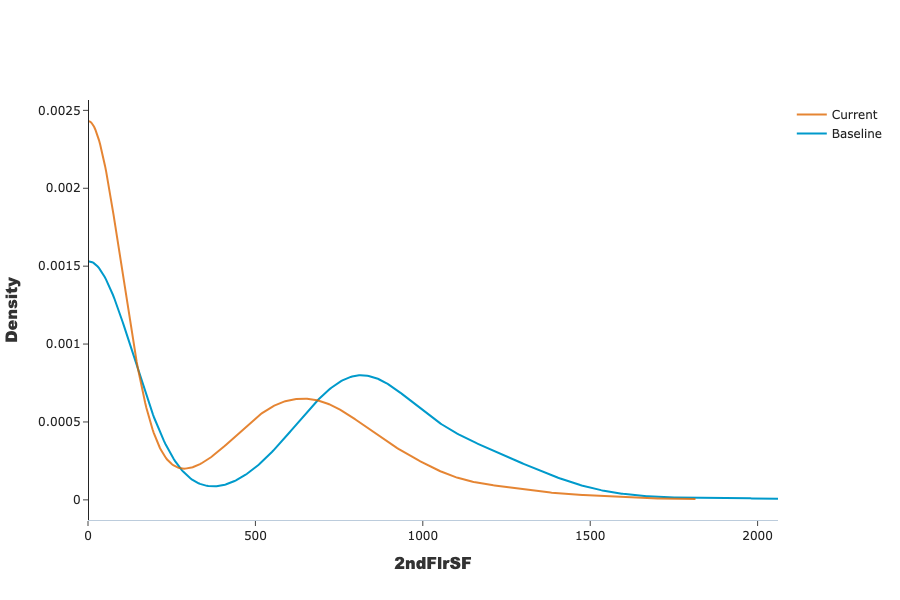

In [ ]:
SD.plot.generate_fig_univariate('2ndFlrSF')

Let's assume that the datascientist is ok with these distribution gaps. 


Let's look at the impact on the deployed model. To do this, let's first build the model.

## Building Supervized Model


In [24]:
from category_encoders import OrdinalEncoder

categorical_features = [col for col in X_df_learning.columns if X_df_learning[col].dtype == 'object']

encoder = OrdinalEncoder(
    cols=categorical_features,
    handle_unknown='ignore',
    return_df=True).fit(X_df_learning)

X_df_learning_encoded=encoder.transform(X_df_learning)

In [25]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_df_learning_encoded, y_df_learning, train_size=0.75, random_state=1)

In [26]:
regressor = LGBMRegressor(n_estimators=200).fit(Xtrain,ytrain)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1455
[LightGBM] [Info] Number of data points in the train set: 636, number of used features: 43
[LightGBM] [Info] Start training from score 143935.696541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

## Third Analysis of results of the data validation

Let's add model to be deployed to the SmartDrift to put into perspective differences in dataset distributions with importance of the features on model. <br />
To get the predicted probability distribution, we also need to add encoding used

In [30]:
X_df_production["MasVnrType"] = X_df_production["MasVnrType"].fillna("NR")
X_df_learning["MasVnrType"] = X_df_learning["MasVnrType"].fillna("NR")
SD = SmartDrift(df_current=X_df_production,
                df_baseline=X_df_learning,
                deployed_model=regressor, # Optional: put in perspective result with importance on deployed model
                encoding=encoder # Optional: if deployed_model and encoder to use this model
               )

In [31]:

%time SD.compile(full_validation=True)

The variable BldgType has mismatching unique values:
[] | ['Two-family Conversion; originally built as one-family dwelling']

The variable BsmtCond has mismatching unique values:
[] | ['Poor -Severe cracking, settling, or wetness']

The variable CentralAir has mismatching unique values:
[] | ['No']

The variable Condition1 has mismatching unique values:
["Within 200' of East-West Railroad"] | ['Adjacent to arterial street', 'Adjacent to postive off-site feature']

The variable Condition2 has mismatching unique values:
['Near positive off-site feature--park, greenbelt, etc.'] | ['Adjacent to arterial street', "Within 200' of North-South Railroad", 'Adjacent to feeder street', 'Adjacent to postive off-site feature', 'Adjacent to North-South Railroad', 'Adjacent to East-West Railroad']

The variable Electrical has mismatching unique values:
[] | ['60 AMP Fuse Box and mostly Romex wiring (Fair)', 'Fuse Box over 60 AMP and all Romex wiring (Average)', '60 AMP Fuse Box and mostly knob & tube

In [32]:
SD.generate_report(    
    output_file='report_house_price_v3.html',    
    title_story="Data validation V3", 
    title_description="""House price Data validation V3""" # Optional: add a subtitle to describe report
    )

### Feature importance overview

This graph compares the importance of variables between the data drift classifier model and the deployed model. This allows us to put into perspective the importance of data drift in relation to the impacts to be expected on the deployed model. If the variable is at the top left, it means that the variable is very important for data drift classification, but that the variable has little influence on the deployed model. If the variable is at the bottom right, it means that the variable has little importance for data drift classification, and that the variable has a lot of influence on the deployed model.

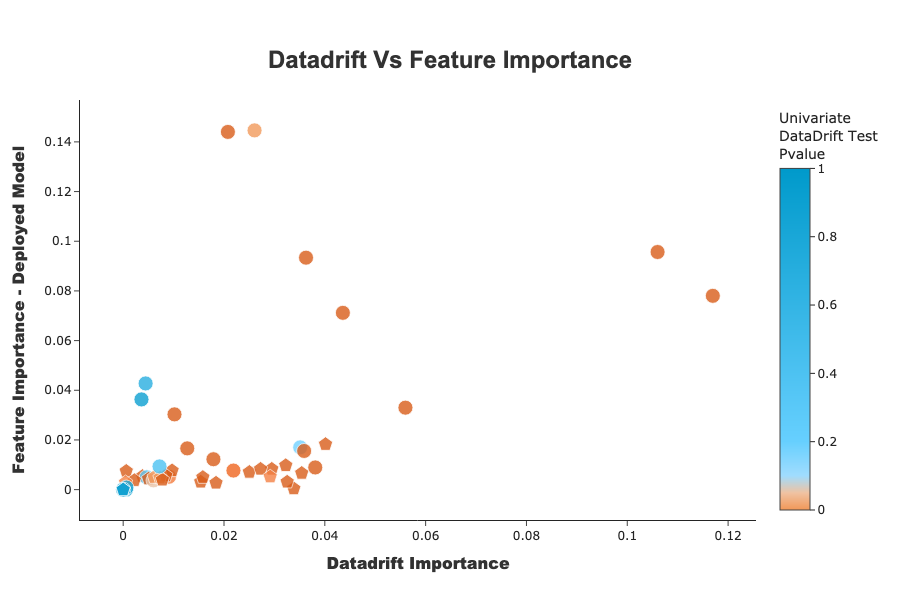

In [ ]:
SD.plot.scatter_feature_importance()

Putting importance of the drift into perspective according to the importance of the model to be deployed, can help the data scientist to validate that his model can be deployed. <br />
Here we see that some features are necessary to analyse

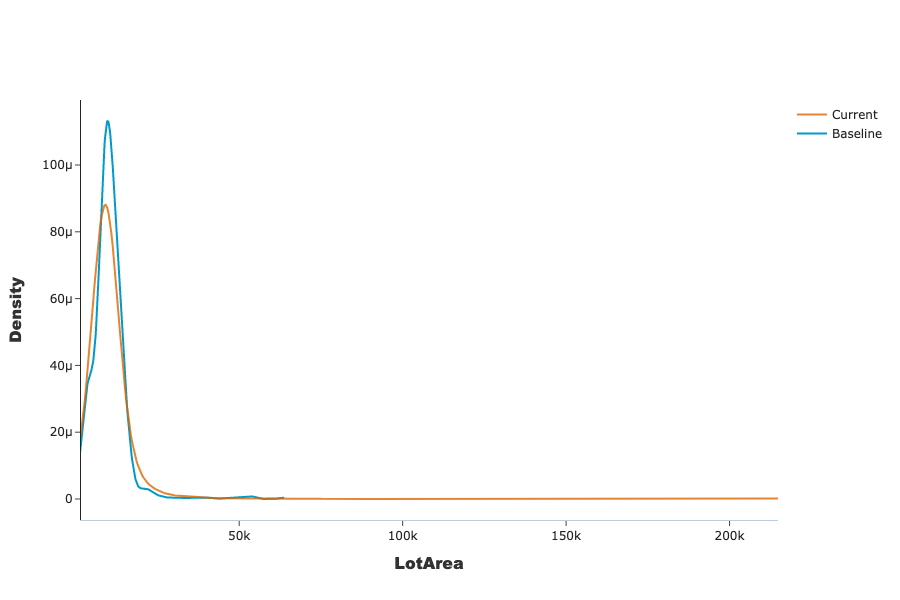

In [ ]:
SD.plot.generate_fig_univariate('LotArea')

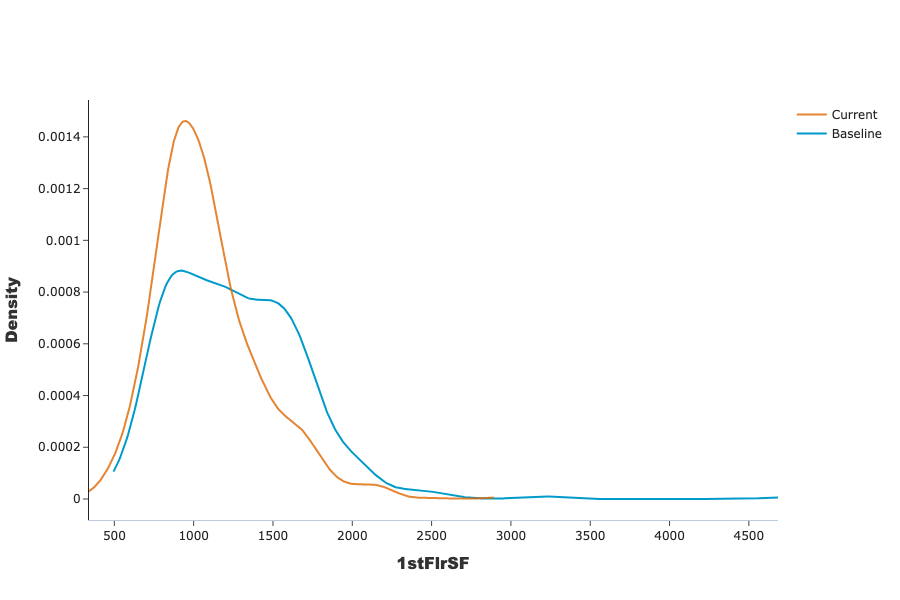

In [ ]:
SD.plot.generate_fig_univariate('1stFlrSF')

We see that for important features, the data in production will not be similar in distributions to that in training

### Distribution of predicted values

This graph shows distributions of the production model outputs on both baseline and current datasets.

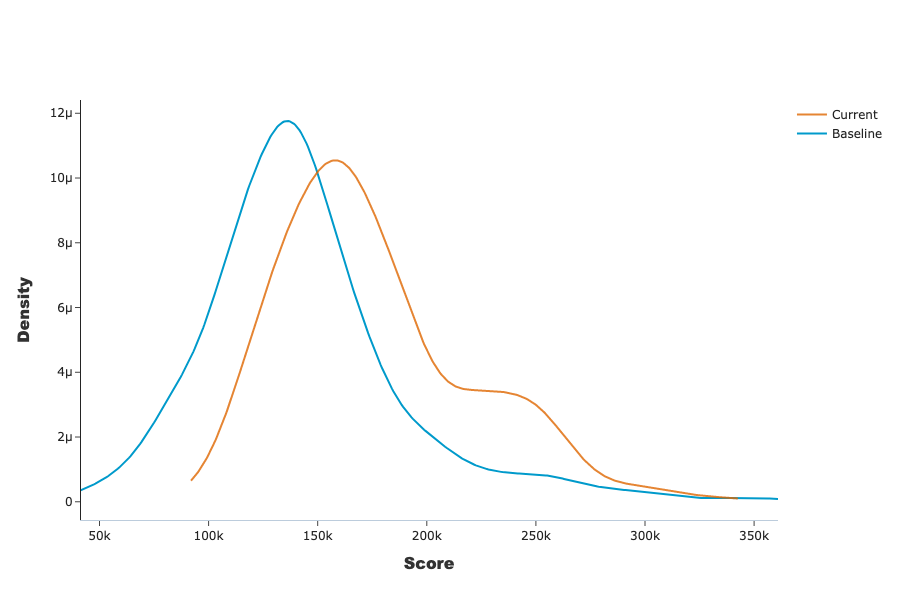

In [ ]:
SD.plot.generate_fig_univariate(df_all=SD.df_predict,col='Score',hue="dataset") # works if deployed_model is filled

Differences between 2 datasets generate a difference in the distribution of the predictions of the deployed model. These differences can have important impacts on the performance of the model in production. <br />
Such differences in predicted probabilities may call into question the decision to deploy the model as is.

Jensen Shannon Divergence (JSD). The JSD measures the effect of a data drift on the deployed model performance. A value close to 0 indicates similar data distributions, while a value close to 1 tend to indicate distinct data distributions with a negative effect on the deployed model performance.

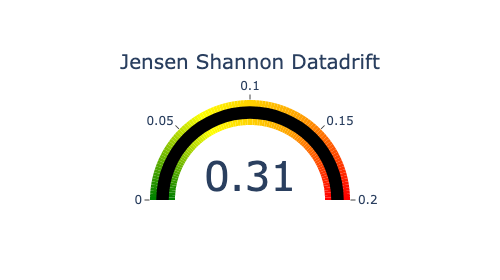

In [ ]:
SD.plot.generate_indicator(
                fig_value=SD.js_divergence,
                height=280,
                width=500,
                title="Jensen Shannon Datadrift",
                min_gauge=0,
                max_gauge=0.2,
            ) #works if deployed_model is filled

With this tutorial, we hope to have detailed how Eurybia can be used in a data validation phase before deploying a model.